<a href="https://colab.research.google.com/github/derekcarey/Covid-19_Vaccine_Tweet_Annotation_BERT/blob/main/Covid_19_Vaccine_Tweet_Annotation_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workbook Initiatlization and Data Preparation

## **Author: Derek Carey**

Corpus data as well as the code used for analysis is provided in a repository at https://github.com/derekcarey/Covid-19_Vaccine_Tweet_Annotation_BERT
. Inquiries should be directed to: derek.carey@outlook.com.[link text](https://)

## **About:**

The Covid-19_Vaccine_Tweet_Annotation_BERT notebook trains on a corpus of COVID-19 vaccine tweets to learn to perform several classification tasks associated with vaccination sentiment. Three models were downloaded from Tensorflow Hub, fined-tuned, and evaluated:

1. bert_en_cased_L-12_H-768_A-12/3
2. electra_base/2
3. bert_en_uncased_L-12_H-768_A-12/3


Always run the following Colab notebook section prior to executing code for any of the three 'Model Evaluation' sections. Due to memory constraints it is recommend to run each model segment as a seperate runtime. 


Install necessary Python libraries using pip. Future package changes require adjustments to code. 

In [1]:
!pip install tensorflow==2.4.1
!pip install  tensorflow-text==2.4.1   
!pip install tf-models-official==2.4
!pip install emoji

     |████████████████████████████████| 394.3MB 37kB/s 
     |████████████████████████████████| 2.9MB 21.2MB/s 
     |████████████████████████████████| 471kB 40.3MB/s 
     |████████████████████████████████| 3.8MB 51.0MB/s 
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 3.4MB 2.9MB/s 
     |████████████████████████████████| 1.1MB 2.9MB/s 
     |████████████████████

Import model packages. Set a random seed for Tensorflow to ensure results are repeatable

In [2]:
import pandas as pd
import os
import nltk
import re
import string
import shutil
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
from official.nlp import optimization  # to create AdamW optmizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import emoji
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from google.colab import files
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

# Set random seed for tensorflow for model consistency
tf.random.set_seed(78)

Check to make sure GPU is in use

In [3]:
# Check to make sure GPU is in use

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Found GPU at: /device:GPU:0
Num GPUs Available:  1


Create a list to store model results. This will be appended once models are evaluated and eventually saved to a file. 

In [4]:
model_final_test_results = list()

The following function removes emojis from corpus text.

In [5]:
# Function: Takes in a text sequence as input and returns a sequence with emojis removed

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

Check to see if the corpus file is already on Github. If not, then download it from the Github repo.

In [6]:
import urllib.request

#set working Directory to where class corpus is saved.
os.chdir('/content')

# Check to see if the corpus file is already on Github. If not, then download it from the Github repo
if not os.path.exists("Covid_Vaccine_Tweet_Corpus.xlsx"):
  url = 'https://github.com/derekcarey/Covid-19_Vaccine_Tweet_Annotation_BERT/blob/main/Covid_Vaccine_Tweet_Corpus.xlsx?raw=true'
  print("download start!")
  filename, headers = urllib.request.urlretrieve(url, filename="Covid_Vaccine_Tweet_Corpus.xlsx")
  print("download complete!")
  print("download file location: ", filename)
  print("download headers: ", headers)


download start!
download complete!
download file location:  Covid_Vaccine_Tweet_Corpus.xlsx
download headers:  Connection: close
Content-Length: 310375
Cache-Control: max-age=300
Content-Security-Policy: default-src 'none'; style-src 'unsafe-inline'; sandbox
Content-Type: application/octet-stream
ETag: "00d74ff2743c790e323fd2f00635b002bd1aac83fb05e6ede8a835c884c561af"
Strict-Transport-Security: max-age=31536000
X-Content-Type-Options: nosniff
X-Frame-Options: deny
X-XSS-Protection: 1; mode=block
X-GitHub-Request-Id: C82A:6F19:4394:BA12:60AFE2C6
Accept-Ranges: bytes
Date: Thu, 27 May 2021 18:19:50 GMT
Via: 1.1 varnish
X-Served-By: cache-hkg17923-HKG
X-Cache: MISS
X-Cache-Hits: 0
X-Timer: S1622139590.169071,VS0,VE334
Vary: Authorization,Accept-Encoding
Access-Control-Allow-Origin: *
X-Fastly-Request-ID: a7b51de5c43402eaff94bf92d8849d07e93c0f6a
Expires: Thu, 27 May 2021 18:24:50 GMT
Source-Age: 0




Set the Google colab directory to /content. Then use the Covid_Vaccine_Tweet_Corpus file to create a dataframe for processing. 

In [7]:
#set working Directory to where class corpus is saved.
os.chdir('/content')

#read in class corpus csv into python
data=pd.read_excel('Covid_Vaccine_Tweet_Corpus.xlsx','Corpus')


The corpus data file should only contain tweets related to vaccines. However, the dataframe is filtered to ensure only related tweets are included.

In [8]:
data = data[data['Vaccine Related']=='Yes']

Several additional fields are added to the corpus dataframe to convert text categories to a binary or categorical number. This step is required for processing labels. 

In [9]:

data['vaccination_label'] = data['Taken a Vaccine?'].apply(lambda x: 1 if x == 'Yes' or x == 'yes' else 0)
data['sentiment_label'] = data['Sentiment'].apply(lambda x: 0 if x == 'Positive' else 1 if x == 'Negative' else 2 if x == 'Neutral' else 2)
data['side_effect_label'] = data['Side Effects Referenced'].apply(lambda x: 1 if x == 'Yes' or x == 'yes' else 0)
data['negative_sentiment_reason_label'] = data['Negative Sentiment Reason'].apply(lambda x: 0 if x == 'Safety' else 1 if x == 'Efficacy'
                                                                         else 2 if x == 'Availability' else 3 if x == 'Other' else 4 if x == 'Not Negative' else 4)

Example of a record text with data (Negative sentiment rason is availability)

In [10]:
data.text[data['negative_sentiment_reason_label']==2].iloc[5]

'I’m an #essentialworker, #veterinarian, live in #YorkRegion(but not a hotspot area code)work in #Halton(but not hotspot area code)Too young for AZ,can’t work from home,can’t get #vaccinated I’m vaccine adjacent,not #vaccineeligible,terrified I’ll get #Covid and so 😡😩#onpoli'

Convert Emoji's in tweets to text so that they can be interpreted by BERT models

In [11]:
# Convert Emoji's in tweets to text so that they can be interpreted by BERT models
data['text'] = data['text'].apply(lambda x: emoji.demojize(x, delimiters=(" ", " "))) # 'game is on fire fire'

In [12]:
# Create a mapping of tfhub models for easy reference in later model construction

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}


The build_classifier_model_binary function is used to generate binary models for vaccine determination and side-effect classification tasks. 

In [13]:
def build_classifier_model_binary():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [14]:
def build_classifier_model_softmax_3_class():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [15]:
def build_classifier_model_softmax_5_class():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [16]:

def create_checkpoint_callback(checkpoint_filepath):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='binary_accuracy',
        mode='max',
        save_best_only=True)
    return checkpoint_callback


    
def create_checkpoint_callback_categorical(checkpoint_filepath):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='categorical_accuracy',
        mode='max',
        save_best_only=True)
    return checkpoint_callback

In [17]:
# Functions for calculating recall, precission, and f1 scores for models. 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Sizing of train, validation, and test datasets is determined by a percentage of the overall corpus size. For the corpus, dataset sizes are set and printed.

In [18]:

train_size = int(0.7 * len(data))
val_size = int(0.10 * len(data))
test_size = int(0.20 * len(data))

print('Train Size: ', train_size)
print('Validation Size: ', val_size)
print('Test Size: ', test_size)

Train Size:  1400
Validation Size:  200
Test Size:  400


In [19]:
from sklearn.utils import shuffle

shuffled_data = shuffle(data, random_state=65)

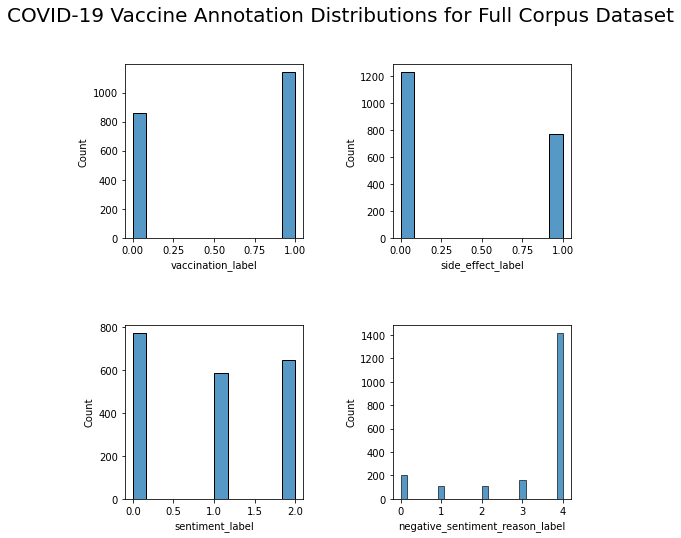

In [20]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(shuffled_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(shuffled_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = shuffled_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=shuffled_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Full Corpus Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [21]:
train_data = shuffled_data[:train_size]

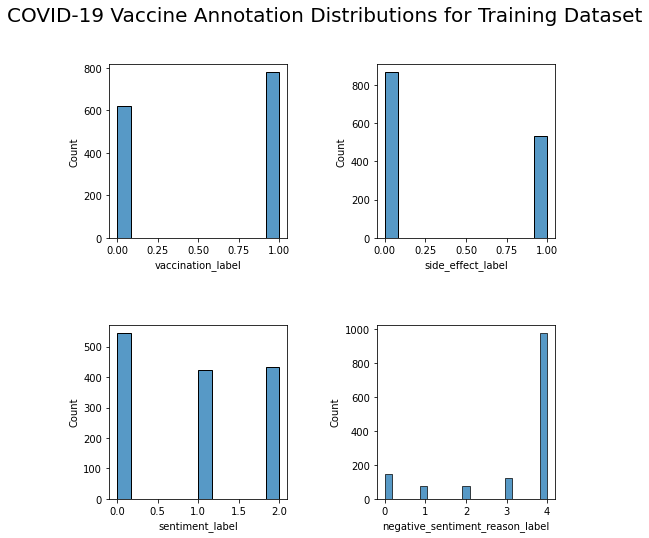

In [22]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(train_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(train_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = train_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=train_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Training Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [23]:
test_data = shuffled_data[train_size:(train_size + test_size)]

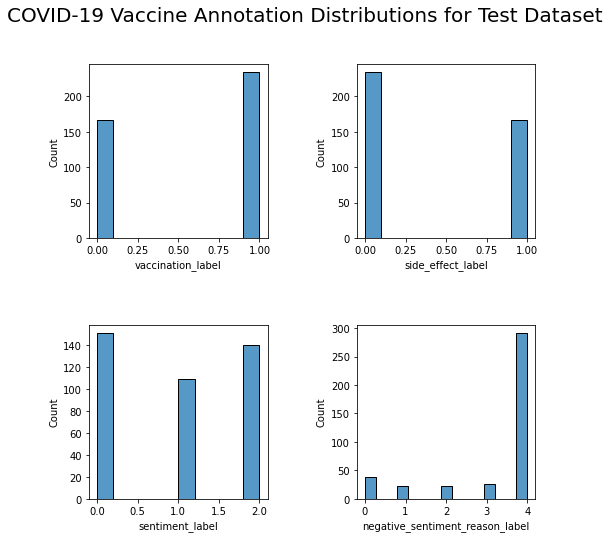

In [24]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(test_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(test_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = test_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=test_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Test Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [25]:
val_data = shuffled_data[(train_size + test_size):]

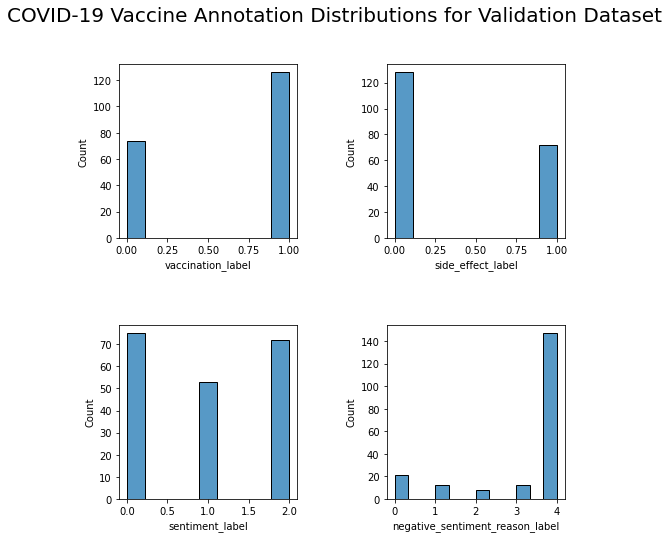

In [26]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(2, 2, 1)
sn.histplot(val_data['vaccination_label'],ax=ax)
ax = fig.add_subplot(2, 2, 2)
sn.histplot(val_data['side_effect_label'],ax=ax)
ax = fig.add_subplot(2, 2, 3)
sn.histplot(data = val_data['sentiment_label'],ax=ax)
ax = fig.add_subplot(2, 2, 4)
sn.histplot(data=val_data['negative_sentiment_reason_label'],ax=ax)
fig.suptitle('COVID-19 Vaccine Annotation Distributions for Validation Dataset',fontsize=20)
fig.fontweight='bold'
plt.show()

In [27]:
m1_train_target = train_data.pop('vaccination_label')
m1_val_target = val_data.pop('vaccination_label')
m1_test_target = test_data.pop('vaccination_label')

m2_train_target = train_data.pop('side_effect_label')
m2_val_target = val_data.pop('side_effect_label')
m2_test_target = test_data.pop('side_effect_label')

m3_train_target = train_data.pop('sentiment_label')
m3_val_target = val_data.pop('sentiment_label')
m3_test_target = test_data.pop('sentiment_label')

m4_train_target = train_data.pop('negative_sentiment_reason_label')
m4_val_target = val_data.pop('negative_sentiment_reason_label')
m4_test_target = test_data.pop('negative_sentiment_reason_label')

In [28]:
m1_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, m1_train_target.values)).batch(16)
m1_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, m1_val_target.values)).batch(16)
m1_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, m1_test_target.values)).batch(16)

m2_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, m2_train_target.values)).batch(16)
m2_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, m2_val_target.values)).batch(16)
m2_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, m2_test_target.values)).batch(16)

m3_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, to_categorical(m3_train_target))).batch(16)
m3_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, to_categorical(m3_val_target))).batch(16)
m3_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, to_categorical(m3_test_target))).batch(16)

m4_train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'].values, to_categorical(m4_train_target))).batch(16)
m4_val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'].values, to_categorical(m4_val_target))).batch(16)
m4_test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'].values, to_categorical(m4_test_target))).batch(16)

In [29]:

# target = data.pop('vaccination_label')

# m0_dataset = tf.data.Dataset.from_tensor_slices((data['id'].values, target.values)).batch(16)
# m1_dataset = tf.data.Dataset.from_tensor_slices((data['text'].values, target.values)).batch(16)

# target = data.pop('side_effect_label')

# m2_dataset = tf.data.Dataset.from_tensor_slices((data['text'].values, target.values)).batch(16)

# target = data.pop('sentiment_label')
# m3_dataset = tf.data.Dataset.from_tensor_slices((data['text'].values, to_categorical(target))).batch(16)


# target = data.pop('negative_sentiment_reason_label')
# m4_dataset = tf.data.Dataset.from_tensor_slices((data['text'].values, to_categorical(target))).batch(16)

# BERT EN CASED Model Evaluation

## BERT EN CASED Classifer - Vaccine Determination

In [30]:

# train_size = int(0.7 * len(m1_dataset))
# val_size = int(0.10 * len(m1_dataset))
# test_size = int(0.20 * len(m1_dataset))


# full_dataset = m1_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# remaining = full_dataset.skip(train_size)
# val_dataset = remaining.take(val_size)
# test_dataset = remaining.skip(val_size)

In [31]:

# train_size = int(0.7 * len(m0_dataset))
# val_size = int(0.10 * len(m0_dataset))
# test_size = int(0.20 * len(m0_dataset))


# full_dataset = m0_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# remaining = full_dataset.skip(train_size)
# val_dataset = remaining.take(val_size)
# test_dataset = remaining.skip(val_size)

In [32]:
# # Generate Cofnusion Matrix from test_dataset - binary classification


# text_list = list()
# dataset_list = list()


# for batch in list(train_dataset.as_numpy_iterator()):

#   for item in batch[0]:

#     text_list.append(item)
#     dataset_list.append('train')
#     #y_pred.append(pred)

# for batch in list(val_dataset.as_numpy_iterator()):

#   for item in batch[0]:

#     text_list.append(item)
#     dataset_list.append('val')
#     #y_pred.append(pred)

# for batch in list(test_dataset.as_numpy_iterator()):

#   for item in batch[0]:

#     text_list.append(item)
#     dataset_list.append('test')




In [33]:
# print(len(text_list))

In [34]:
# pd.DataFrame(text_list, dataset_list).to_csv('testing_id4.csv')

In [35]:
# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))

In [36]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

#,tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

In [37]:
epochs = 10

checkpoint_filepath = './m1_bert_cased/checkpoint'
model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m1_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [38]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [39]:
bert_model_name = 'bert_en_cased_L-12_H-768_A-12' 


tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3


In [40]:
bert_cased_m1 = build_classifier_model_binary()

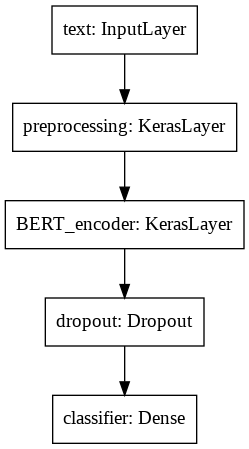

In [41]:
tf.keras.utils.plot_model(bert_cased_m1)

In [42]:


bert_cased_m1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [43]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m1.fit(m1_train_dataset,validation_data=m1_val_dataset, epochs=epochs,callbacks = [model_checkpoint_callback]) #callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 43s 298ms/step - loss: 0.6519 - binary_accuracy: 0.5639 - f1_m: 0.3005 - precision_m: 0.4449 - recall_m: 0.2650 - val_loss: 0.3421 - val_binary_accuracy: 0.8650 - val_f1_m: 0.8861 - val_precision_m: 0.8772 - val_recall_m: 0.9170
Epoch 2/10
88/88 [==============================] - 25s 287ms/step - loss: 0.2877 - binary_accuracy: 0.8994 - f1_m: 0.9005 - precision_m: 0.9309 - recall_m: 0.8894 - val_loss: 0.3602 - val_binary_accuracy: 0.8800 - val_f1_m: 0.9027 - val_precision_m: 0.9211 - val_recall_m: 0.8982
Epoch 3/10
88/88 [==============================] - 25s 286ms/step - loss: 0.1328 - binary_accuracy: 0.9664 - f1_m: 0.9681 - precision_m: 0.9813 - recall_m: 0.9596 - val_loss: 0.4991 - val_binary_accuracy: 0.8900 - val_f1_m: 0.9108 - val_precision_m: 0.9377 - val_recall_m: 0.8982
Epoch 4/10
88/88 [==============================] - 25s 286ms/step - loss: 0

In [44]:
bert_cased_m1.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


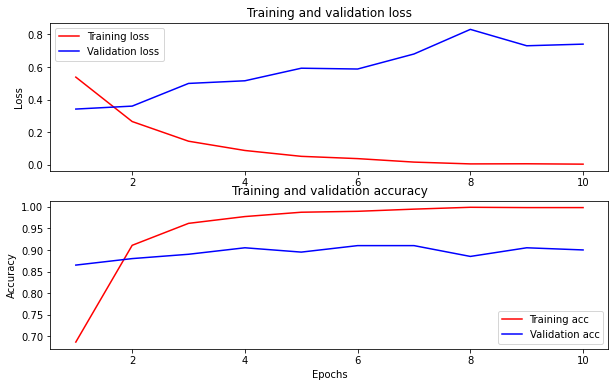

In [45]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [46]:
loss, accuracy, f1, precision, recall = bert_cased_m1.evaluate(m1_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 89.499998
Test Loss:  0.5569255352020264
Test Precision:  0.9554603695869446
Test Recall:  0.8600655198097229
Test f1_score:  0.8987138867378235


In [47]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m1_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_cased_m1.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [48]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]



# Commented out code can be used to print text with predicted/actual labels. This is helpful for troubleshooting
# count = 0 

# while count < len(text_list):
#   print(text_list[count], predicted_categories[count], true_label_list[count])
#   count += 1


In [49]:
cm_1 = confusion_matrix(true_label_list, predicted_categories)

Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Taken Vaccine?')

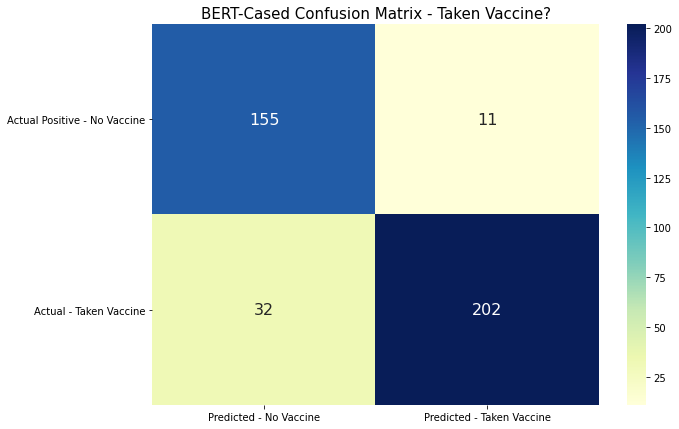

In [50]:


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_1, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Taken Vaccine?',fontsize = 15)

In [51]:


# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)




# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m1', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.8925
Recall Score:  0.8925
f1 Score:  0.8925
Accuracy Score 0.8925
Macro Precision Score:  0.8886169064296654
Macro Recall Score:  0.8984914015034497
Macro f1 Score:  0.8909950504147892
Accuracy Score 0.8925


## BERT EN CASED Classifier - Side-Effect Determintation

In [52]:
# train_size = int(0.7 * len(m2_dataset))
# val_size = int(0.10 * len(m2_dataset))
# test_size = int(0.20 * len(m2_dataset))


# full_dataset = m2_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [53]:
epochs = 10

checkpoint_filepath = './m2_bert_cased/checkpoint'

model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m2_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [54]:
bert_cased_m2 = build_classifier_model_binary()


In [55]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [56]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [57]:
bert_cased_m2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [58]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m2.fit(m2_train_dataset,validation_data=m2_val_dataset, epochs=epochs, callbacks = [model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 40s 295ms/step - loss: 0.6584 - binary_accuracy: 0.6330 - f1_m: 0.0330 - precision_m: 0.0702 - recall_m: 0.0250 - val_loss: 0.3381 - val_binary_accuracy: 0.8500 - val_f1_m: 0.7302 - val_precision_m: 0.9692 - val_recall_m: 0.6066
Epoch 2/10
88/88 [==============================] - 25s 286ms/step - loss: 0.3944 - binary_accuracy: 0.8285 - f1_m: 0.6847 - precision_m: 0.8682 - recall_m: 0.6174 - val_loss: 0.3334 - val_binary_accuracy: 0.8850 - val_f1_m: 0.7611 - val_precision_m: 0.9872 - val_recall_m: 0.6501
Epoch 3/10
88/88 [==============================] - 25s 286ms/step - loss: 0.2185 - binary_accuracy: 0.9205 - f1_m: 0.8504 - precision_m: 0.9347 - recall_m: 0.8068 - val_loss: 0.4402 - val_binary_accuracy: 0.8900 - val_f1_m: 0.8295 - val_precision_m: 0.8397 - val_recall_m: 0.8429
Epoch 4/10
88/88 [==============================] - 25s 286ms/step - loss: 0

In [59]:
bert_cased_m2.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


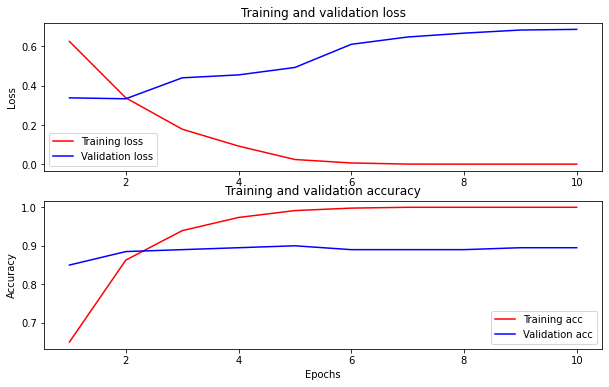

In [60]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [61]:
loss, accuracy, f1, precision, recall = bert_cased_m2.evaluate(m2_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 87.000000
Test Loss:  0.9974595904350281
Test Precision:  0.8448730707168579
Test Recall:  0.8515830039978027
Test f1_score:  0.8324918150901794


In [62]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m2_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_cased_m2.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


Convert probability vector into binary value of 0 (has not recieved vaccine) or 1 (has received a vaccine or has one scheduled)


In [63]:
# Convert probability vector to discrete 0 or 1 value (0 - no side effects, 1 - side effects)
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]

In [64]:
cm_2 = confusion_matrix(true_label_list, predicted_categories)

Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Side Effect Reference')

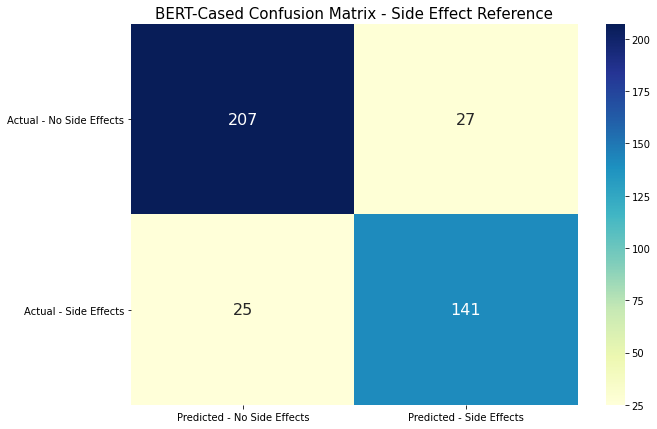

In [65]:

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_2, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Side Effect Reference',fontsize = 15)

In [66]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m2', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.87
Recall Score:  0.87
f1 Score:  0.87
Accuracy Score 0.87
Macro Precision Score:  0.8657635467980296
Macro Recall Score:  0.8670064874884151
Macro f1 Score:  0.8663616972064455


## BERT EN CASED Classifier - Sentiment Analysis

In [67]:
# train_size = int(0.7 * len(m3_dataset))
# val_size = int(0.10 * len(m3_dataset))
# test_size = int(0.20 * len(m3_dataset))


# full_dataset = m3_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [68]:
epochs = 10

checkpoint_filepath = './m3_bert_cased/checkpoint'

model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m3_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [69]:
bert_cased_m3 = build_classifier_model_softmax_3_class()


In [70]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [71]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [72]:


bert_cased_m3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [73]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m3.fit(m3_train_dataset,validation_data=m3_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 40s 295ms/step - loss: 1.5770 - categorical_accuracy: 0.3744 - f1_m: 0.3094 - precision_m: 0.3971 - recall_m: 0.2715 - val_loss: 0.6100 - val_categorical_accuracy: 0.7600 - val_f1_m: 0.7394 - val_precision_m: 0.7870 - val_recall_m: 0.7019
Epoch 2/10
88/88 [==============================] - 25s 286ms/step - loss: 0.7491 - categorical_accuracy: 0.7012 - f1_m: 0.6810 - precision_m: 0.7233 - recall_m: 0.6462 - val_loss: 0.5915 - val_categorical_accuracy: 0.7700 - val_f1_m: 0.7679 - val_precision_m: 0.7823 - val_recall_m: 0.7548
Epoch 3/10
88/88 [==============================] - 25s 287ms/step - loss: 0.4312 - categorical_accuracy: 0.8360 - f1_m: 0.8348 - precision_m: 0.8493 - recall_m: 0.8215 - val_loss: 0.7347 - val_categorical_accuracy: 0.7800 - val_f1_m: 0.7748 - val_precision_m: 0.7861 - val_recall_m: 0.7644
Epoch 4/10
88/88 [============================

In [74]:
bert_cased_m3.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


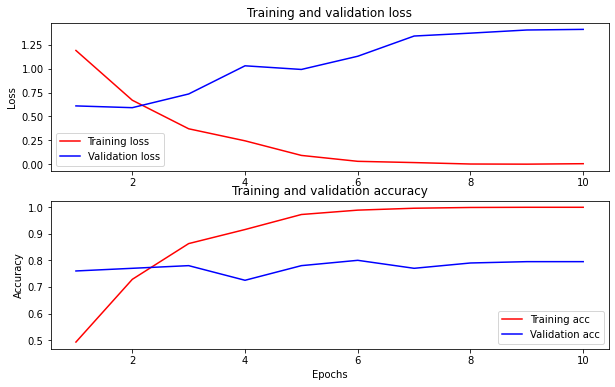

In [75]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [76]:
loss, accuracy, f1, precision, recall = bert_cased_m3.evaluate(m3_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 75.749999
Test Loss:  1.5134820938110352
Test Precision:  0.7569999694824219
Test Recall:  0.7549999952316284
Test f1_score:  0.7559677362442017


In [77]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m3_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.argmax(bert_cased_m3.predict(tf.constant([item])),1))
    y_pred = tf.argmax(bert_cased_m3.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    print(tf.argmax(item))
    true_label_list.append(tf.argmax(item))


tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype

Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Vaccine Sentiment')

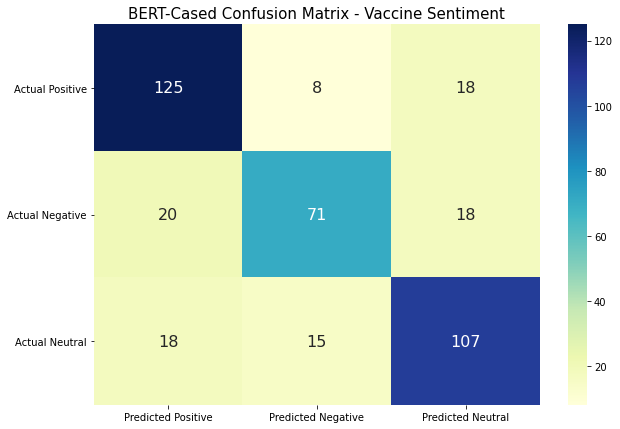

In [78]:
cm_3 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_3, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Vaccine Sentiment',fontsize = 15)

In [79]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m3', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.7575
Recall Score:  0.7575
f1 Score:  0.7575
Accuracy Score 0.7575
Macro Precision Score:  0.75681402094403
Macro Recall Score:  0.7478254768703763
Macro f1 Score:  0.7506231595648817



 ## BERT EN CASED Classifier - Negative Sentiment Reason


In [80]:
# train_size = int(0.7 * len(m4_dataset))
# val_size = int(0.10 * len(m4_dataset))
# test_size = int(0.20 * len(m4_dataset))


# full_dataset = m4_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [81]:
epochs = 10

checkpoint_filepath = './m4_bert_cased/checkpoint'
model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m4_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [82]:
bert_cased_m4 = build_classifier_model_softmax_5_class()

In [83]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [84]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [85]:
bert_cased_m4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [86]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_cased_m4.fit(m4_train_dataset,validation_data=m4_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/10
88/88 [==============================] - 40s 295ms/step - loss: 1.9349 - categorical_accuracy: 0.2496 - f1_m: 0.1759 - precision_m: 0.2204 - recall_m: 0.1608 - val_loss: 0.7393 - val_categorical_accuracy: 0.7350 - val_f1_m: 0.7364 - val_precision_m: 0.8104 - val_recall_m: 0.6779
Epoch 2/10
88/88 [==============================] - 25s 287ms/step - loss: 0.8246 - categorical_accuracy: 0.6996 - f1_m: 0.7016 - precision_m: 0.8368 - recall_m: 0.6138 - val_loss: 0.7640 - val_categorical_accuracy: 0.7650 - val_f1_m: 0.7959 - val_precision_m: 0.8328 - val_recall_m: 0.7644
Epoch 3/10
88/88 [==============================] - 25s 286ms/step - loss: 0.5426 - categorical_accuracy: 0.8148 - f1_m: 0.7977 - precision_m: 0.8645 - recall_m: 0.7448 - val_loss: 0.6228 - val_categorical_accuracy: 0.7950 - val_f1_m: 0.8020 - val_precision_m: 0.8523 - val_recall_m: 0.7596
Epoch 4/10
88/88 [============================

In [87]:
bert_cased_m4.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


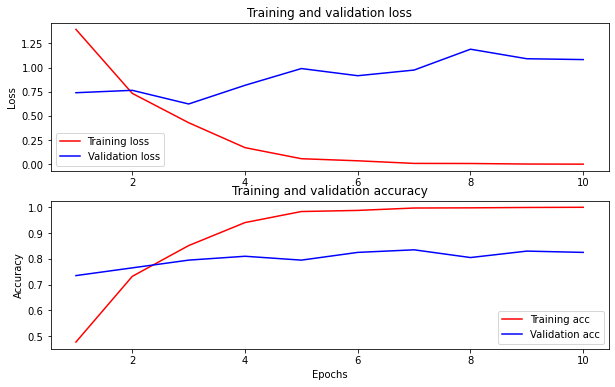

In [88]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [89]:
loss, accuracy, f1, precision, recall = bert_cased_m4.evaluate(m4_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 81.000000
Test Loss:  1.193010687828064
Test Precision:  0.8084999918937683
Test Recall:  0.8050000071525574
Test f1_score:  0.806693434715271


In [90]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m4_test_dataset.as_numpy_iterator()):

  for item in batch[0]:
    #print(tf.argmax(classifier_model_sentiment.predict(tf.constant([item])),1))
    y_pred = tf.argmax(bert_cased_m4.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    #print(tf.argmax(item))
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason')

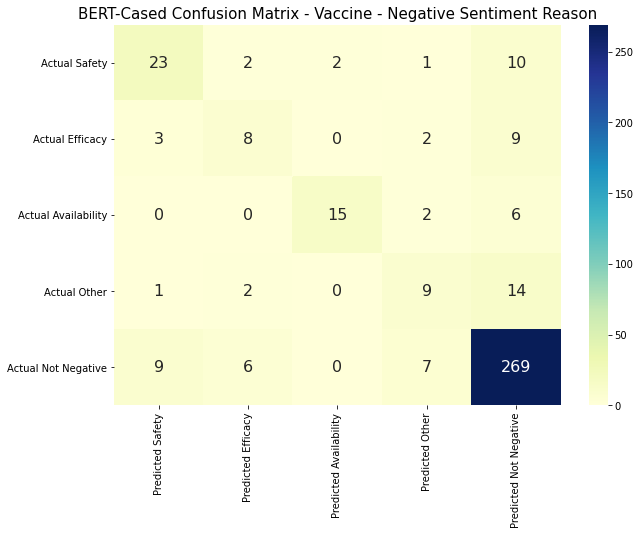

In [91]:
cm_4 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_4, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

In [92]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_cased_m4', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.81
Recall Score:  0.81
f1 Score:  0.81
Accuracy Score 0.81
Macro Precision Score:  0.6535268652915711
Macro Recall Score:  0.5783251812315957
Macro f1 Score:  0.6105527902071788


Text(0.5, 1.0, 'BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason')

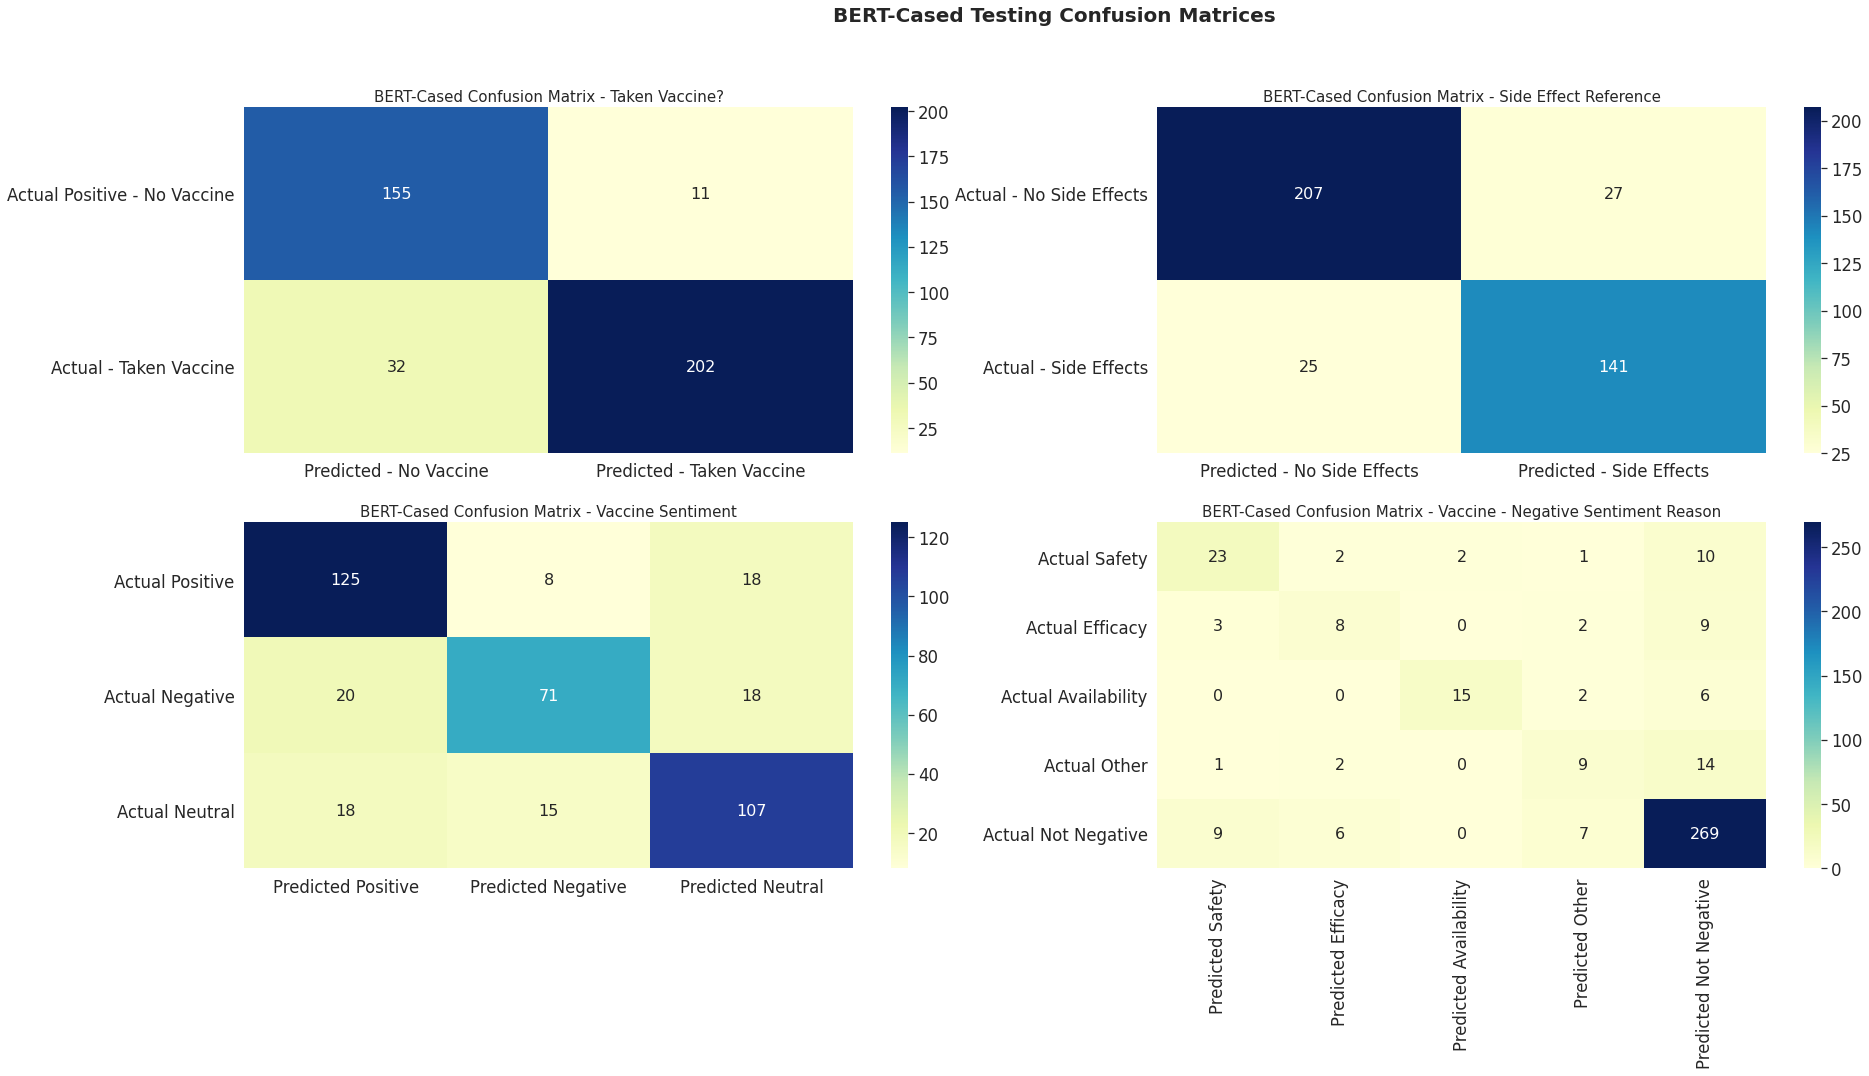

In [93]:
sn.set(font_scale=1.5)
fig, axes = plt.subplots(2, 2, figsize=(30, 14))

fig.suptitle('BERT-Cased Testing Confusion Matrices',fontsize = 20,fontweight='bold')
a = sn.heatmap(cm_1, ax=axes[0,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')
a.set_title('BERT-Cased Confusion Matrix - Taken Vaccine?',fontsize = 15)
b = sn.heatmap(cm_2, ax=axes[0,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')
b.set_title('BERT-Cased Confusion Matrix - Side Effect Reference',fontsize = 15)
c = sn.heatmap(cm_3,ax=axes[1,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')
c.set_title('BERT-Cased Confusion Matrix - Vaccine Sentiment',fontsize = 15)
d = sn.heatmap(data=cm_4, ax=axes[1,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')
d.set_title('BERT-Cased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

# ELECTRA Model Evaluation

## ELECTRA Classifier - Vaccine Determintation

In [94]:
tf.random.set_seed(3)

In [95]:
bert_model_name = 'electra_base' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [96]:
# train_size = int(0.7 * len(m1_dataset))
# val_size = int(0.10 * len(m1_dataset))
# test_size = int(0.20 * len(m1_dataset))


# full_dataset = m1_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [97]:
epochs = 10

checkpoint_filepath = './m1_electra_base/checkpoint'
model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m1_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [98]:
electra_m1 = build_classifier_model_binary()

In [99]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [100]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [101]:
electra_m1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [102]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m1.fit(m1_train_dataset,validation_data=m1_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 40s 294ms/step - loss: 0.6265 - binary_accuracy: 0.5991 - f1_m: 0.5160 - precision_m: 0.6974 - recall_m: 0.4459 - val_loss: 0.3133 - val_binary_accuracy: 0.8900 - val_f1_m: 0.9103 - val_precision_m: 0.9524 - val_recall_m: 0.8885
Epoch 2/10
88/88 [==============================] - 25s 287ms/step - loss: 0.2557 - binary_accuracy: 0.9065 - f1_m: 0.9053 - precision_m: 0.9452 - recall_m: 0.8834 - val_loss: 0.3591 - val_binary_accuracy: 0.9000 - val_f1_m: 0.9209 - val_precision_m: 0.9454 - val_recall_m: 0.9106
Epoch 3/10
88/88 [==============================] - 25s 287ms/step - loss: 0.1406 - binary_accuracy: 0.9553 - f1_m: 0.9526 - precision_m: 0.9788 - recall_m: 0.9326 - val_loss: 0.4133 - val_binary_accuracy: 0.9050 - val_f1_m: 0.9246 - val_precision_m: 0.9299 - val_recall_m: 0.9294
Epoch 4/10
88/88 [==============================] - 25s 286ms/step - loss: 0.0560 - binary_accura

In [103]:
electra_m1.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


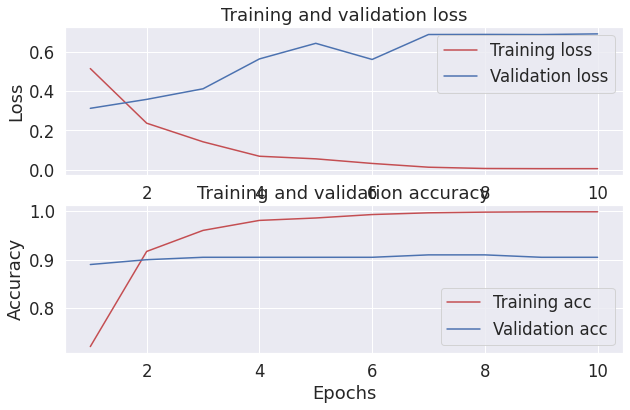

In [104]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [105]:
loss, accuracy, f1, precision, recall = electra_m1.evaluate(m1_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 94.499999
Test Loss:  0.34022247791290283
Test Precision:  0.9611746072769165
Test Recall:  0.9440802931785583
Test f1_score:  0.9508236646652222


In [106]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m1_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifier_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(electra_m1.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [107]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]


count = 0 

while count < len(text_list):
  print(text_list[count], predicted_categories[count], true_label_list[count])
  count += 1


b'Today dose one of covid 19 vaccine accomplished for both myself and my husband  party_popper  party_popper  party_popper  I nearly cried, because after dose two is accomplished for everyone here I\xe2\x80\x99ll actually have the chance to see my kid that I\xe2\x80\x99ve only seen 2 times in the last 14 months again.  pleading_face ' 1 1
b'I AM THANKFUL TO JOE BIDEN FOR GETTING ME A COVID VACCINE!' 1 1
b'I am not gettin no covid vaccine' 0 0
b'Ya girl got her negative Covid result back this morning (which I knew it would be) and is set-up to get her first (maybe only??) vaccine shot at 4:20. \n\nB L A Z E I T.' 1 1
b'if i\xe2\x80\x99m asleep approx 5 hours after my second covid vaccine will i not feel the effects' 1 1
b'If I have to explain ONE MORE TIME to people on how vaccine is not a complete cure that makes you invincible to covid-19 I. Will. Riot!' 0 0
b"Finally had my first covid vaccine. All this time waiting turns out they had a wrong number for me on their system and I've be

Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Taken Vaccine?')

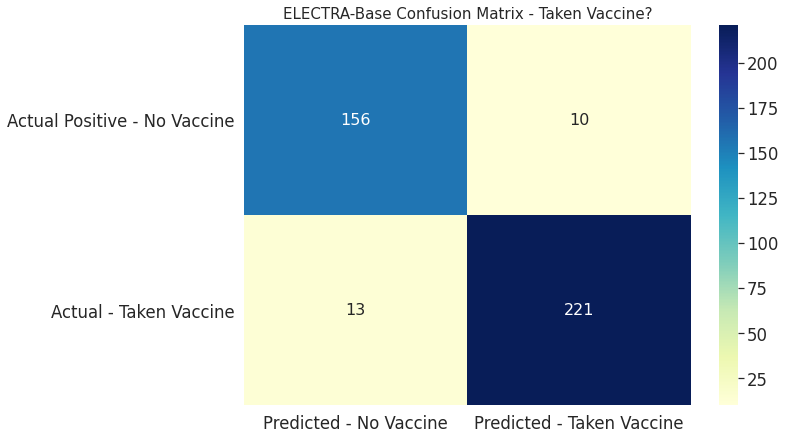

In [108]:
cm_1 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_1, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Taken Vaccine?',fontsize = 15)

In [109]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m1', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.9425
Recall Score:  0.9425
f1 Score:  0.9425
Accuracy Score 0.9425
Macro Precision Score:  0.93989343989344
Macro Recall Score:  0.9421017402945113
Macro f1 Score:  0.9409404589953458


## ELECTRA Classifier - Side-Effect Determination

In [110]:
# train_size = int(0.7 * len(m2_dataset))
# val_size = int(0.10 * len(m2_dataset))
# test_size = int(0.20 * len(m2_dataset))


# full_dataset = m2_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [111]:
epochs = 10

checkpoint_filepath = './m2_electra_base/checkpoint'

model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m2_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [112]:
electra_m2 = build_classifier_model_binary()


In [113]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [114]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [115]:
electra_m2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [116]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m2.fit(m2_train_dataset,validation_data=m2_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 40s 295ms/step - loss: 0.6596 - binary_accuracy: 0.6353 - f1_m: 0.0807 - precision_m: 0.1708 - recall_m: 0.0654 - val_loss: 0.3339 - val_binary_accuracy: 0.8450 - val_f1_m: 0.7125 - val_precision_m: 0.9679 - val_recall_m: 0.5848
Epoch 2/10
88/88 [==============================] - 25s 286ms/step - loss: 0.3702 - binary_accuracy: 0.8430 - f1_m: 0.7263 - precision_m: 0.8786 - recall_m: 0.6687 - val_loss: 0.2155 - val_binary_accuracy: 0.9300 - val_f1_m: 0.8893 - val_precision_m: 0.9736 - val_recall_m: 0.8272
Epoch 3/10
88/88 [==============================] - 25s 286ms/step - loss: 0.1688 - binary_accuracy: 0.9396 - f1_m: 0.9073 - precision_m: 0.9320 - recall_m: 0.9061 - val_loss: 0.3986 - val_binary_accuracy: 0.9100 - val_f1_m: 0.8584 - val_precision_m: 0.9612 - val_recall_m: 0.7905
Epoch 4/10
88/88 [==============================] - 25s 286ms/step - loss: 0.1331 - binary_accura

In [117]:
electra_m2.load_weights(checkpoint_filepath)

dict_keys(['loss', 'binary_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


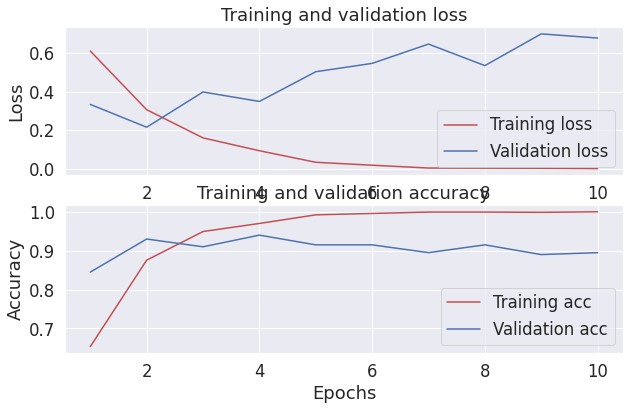

In [118]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [119]:
loss, accuracy, f1, precision, recall = electra_m2.evaluate(m2_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 89.249998
Test Loss:  0.8031043410301208
Test Precision:  0.8575583696365356
Test Recall:  0.8942511081695557
Test f1_score:  0.8632471561431885


In [120]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m2_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(electra_m2.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [121]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]

'''
count = 0 

while count < len(text_list):
  print(text_list[count], predicted_categories[count], true_label_list[count])
  count += 1
'''

'\ncount = 0 \n\nwhile count < len(text_list):\n  print(text_list[count], predicted_categories[count], true_label_list[count])\n  count += 1\n'

Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Side Effect Reference')

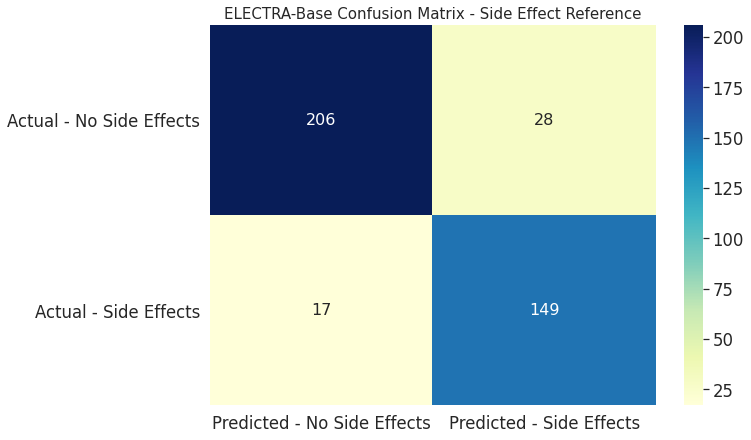

In [122]:
cm_2 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_2, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Side Effect Reference',fontsize = 15)

In [123]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m2', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.8875
Recall Score:  0.8875
f1 Score:  0.8875
Accuracy Score 0.8875
Macro Precision Score:  0.8827873628740088
Macro Recall Score:  0.8889661208938318
Macro f1 Score:  0.88516819669412


## ELECTRA Classifier - Sentiment Analysis

In [124]:
# train_size = int(0.7 * len(m3_dataset))
# val_size = int(0.10 * len(m3_dataset))
# test_size = int(0.20 * len(m3_dataset))


# full_dataset = m3_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [125]:
epochs = 10

checkpoint_filepath = './m3_electra_base/checkpoint'

model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m3_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [126]:
electra_m3 = build_classifier_model_softmax_3_class()


In [127]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [128]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [129]:
electra_m3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [130]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m3.fit(m3_train_dataset,validation_data=m3_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 42s 297ms/step - loss: 1.1403 - categorical_accuracy: 0.3916 - f1_m: 0.2546 - precision_m: 0.4185 - recall_m: 0.1941 - val_loss: 0.6639 - val_categorical_accuracy: 0.6950 - val_f1_m: 0.6747 - val_precision_m: 0.7401 - val_recall_m: 0.6250
Epoch 2/10
88/88 [==============================] - 25s 287ms/step - loss: 0.7297 - categorical_accuracy: 0.6983 - f1_m: 0.6841 - precision_m: 0.7302 - recall_m: 0.6461 - val_loss: 0.6864 - val_categorical_accuracy: 0.7400 - val_f1_m: 0.7487 - val_precision_m: 0.7633 - val_recall_m: 0.7356
Epoch 3/10
88/88 [==============================] - 25s 287ms/step - loss: 0.4608 - categorical_accuracy: 0.8251 - f1_m: 0.8234 - precision_m: 0.8391 - recall_m: 0.8089 - val_loss: 0.7283 - val_categorical_accuracy: 0.7600 - val_f1_m: 0.7629 - val_precision_m: 0.7663 - val_recall_m: 0.7596
Epoch 4/10
88/88 [==============================] - 25s 286ms/step 

In [131]:
electra_m3.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


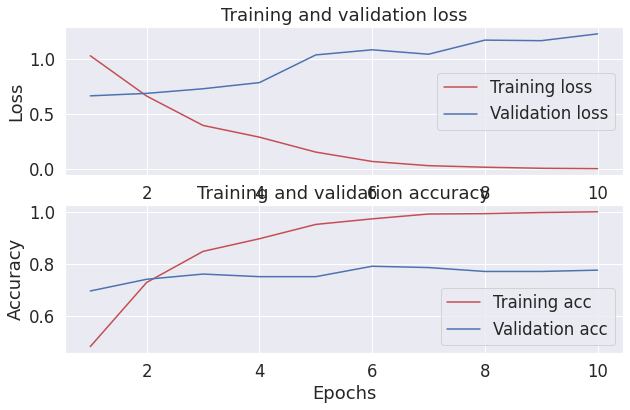

In [132]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [133]:
loss, accuracy, f1, precision, recall = electra_m3.evaluate(m3_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 79.000002
Test Loss:  1.108677625656128
Test Precision:  0.7931666374206543
Test Recall:  0.7900000214576721
Test f1_score:  0.7915322184562683


In [134]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m3_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.argmax(bert_cased_m3.predict(tf.constant([item])),1))
    y_pred = tf.argmax(electra_m3.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    #print(tf.argmax(item))
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Vaccine Sentiment')

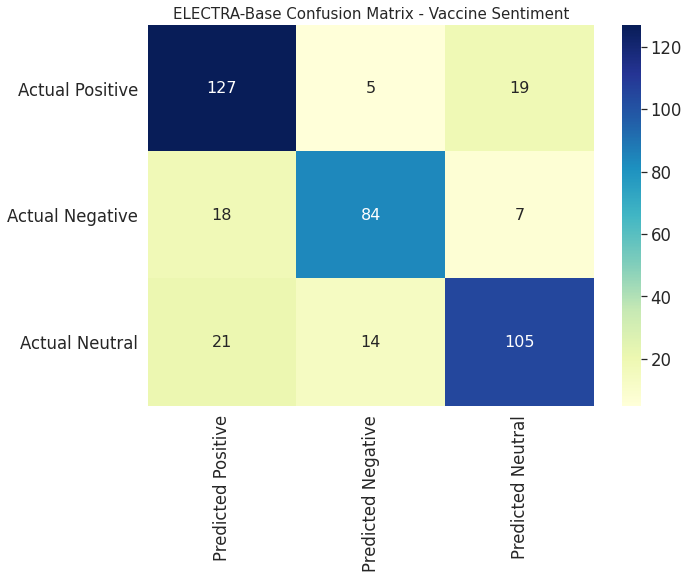

In [135]:
cm_3 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_3, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Vaccine Sentiment',fontsize = 15)

In [136]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m3', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.79
Recall Score:  0.79
f1 Score:  0.79
Accuracy Score 0.79
Macro Precision Score:  0.7940403130345438
Macro Recall Score:  0.7872339348279563
Macro f1 Score:  0.7895408029730557


## ELECTRA Classifier - Negative Sentiment Reason

In [137]:
# train_size = int(0.7 * len(m4_dataset))
# val_size = int(0.10 * len(m4_dataset))
# test_size = int(0.20 * len(m4_dataset))


# full_dataset = m4_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [138]:
epochs = 10

checkpoint_filepath = './m4_electra_base/checkpoint'
model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m4_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [139]:
electra_m4 = build_classifier_model_softmax_5_class()

In [140]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [141]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [142]:
electra_m4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [143]:
print(f'Training model with {tfhub_handle_encoder}')
history = electra_m4.fit(m4_train_dataset,validation_data=m4_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
88/88 [==============================] - 40s 295ms/step - loss: 1.3544 - categorical_accuracy: 0.4645 - f1_m: 0.3047 - precision_m: 0.3385 - recall_m: 0.2890 - val_loss: 0.6765 - val_categorical_accuracy: 0.7350 - val_f1_m: 0.7622 - val_precision_m: 0.8336 - val_recall_m: 0.7067
Epoch 2/10
88/88 [==============================] - 25s 286ms/step - loss: 0.7731 - categorical_accuracy: 0.6941 - f1_m: 0.7005 - precision_m: 0.8539 - recall_m: 0.6061 - val_loss: 0.6672 - val_categorical_accuracy: 0.8000 - val_f1_m: 0.8162 - val_precision_m: 0.8618 - val_recall_m: 0.7788
Epoch 3/10
88/88 [==============================] - 25s 286ms/step - loss: 0.4270 - categorical_accuracy: 0.8317 - f1_m: 0.8288 - precision_m: 0.8973 - recall_m: 0.7737 - val_loss: 0.6183 - val_categorical_accuracy: 0.8350 - val_f1_m: 0.8320 - val_precision_m: 0.8484 - val_recall_m: 0.8173
Epoch 4/10
88/88 [==============================] - 25s 286ms/step 

In [144]:
electra_m4.load_weights(checkpoint_filepath)

dict_keys(['loss', 'categorical_accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


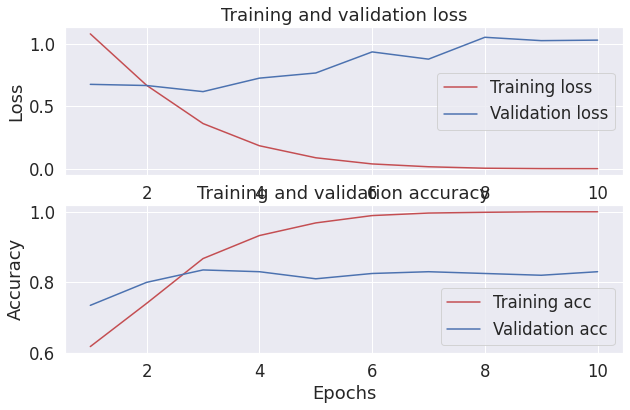

In [145]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [146]:
loss, accuracy, f1, precision, recall = electra_m4.evaluate(m4_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

Test Accuracy: 86.500001
Test Loss:  0.8226606845855713
Test Precision:  0.8666666150093079
Test Recall:  0.8600000143051147
Test f1_score:  0.8632256984710693


In [147]:
# Generate Cofnusion Matrix from test_dataset - categorical classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m4_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    y_pred = tf.argmax(electra_m4.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    #print(tf.argmax(item))
    true_label_list.append(tf.argmax(item))


Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason')

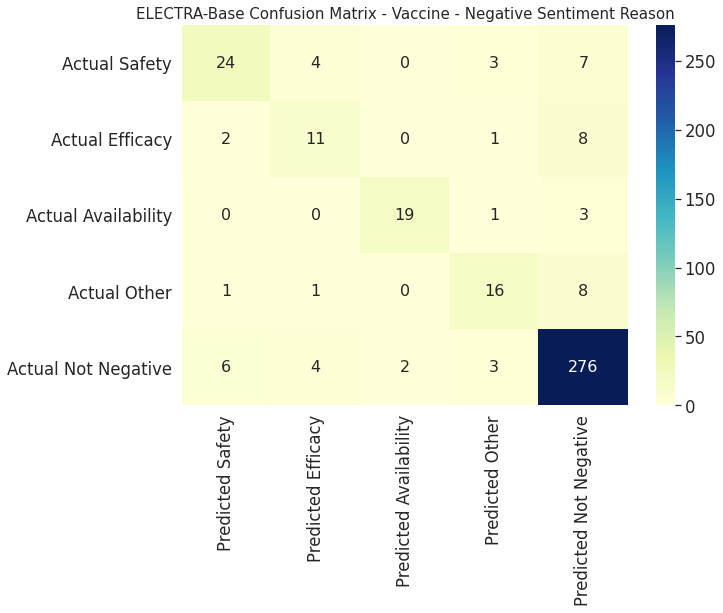

In [148]:
cm_4 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_4, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

In [149]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'electra_base_m4', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

Precision Score:  0.865
Recall Score:  0.865
f1 Score:  0.865
Accuracy Score 0.865
Macro Precision Score:  0.752521716693902
Macro Recall Score:  0.7043008255044396
Macro f1 Score:  0.7268724518401739


Text(0.5, 1.0, 'ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason')

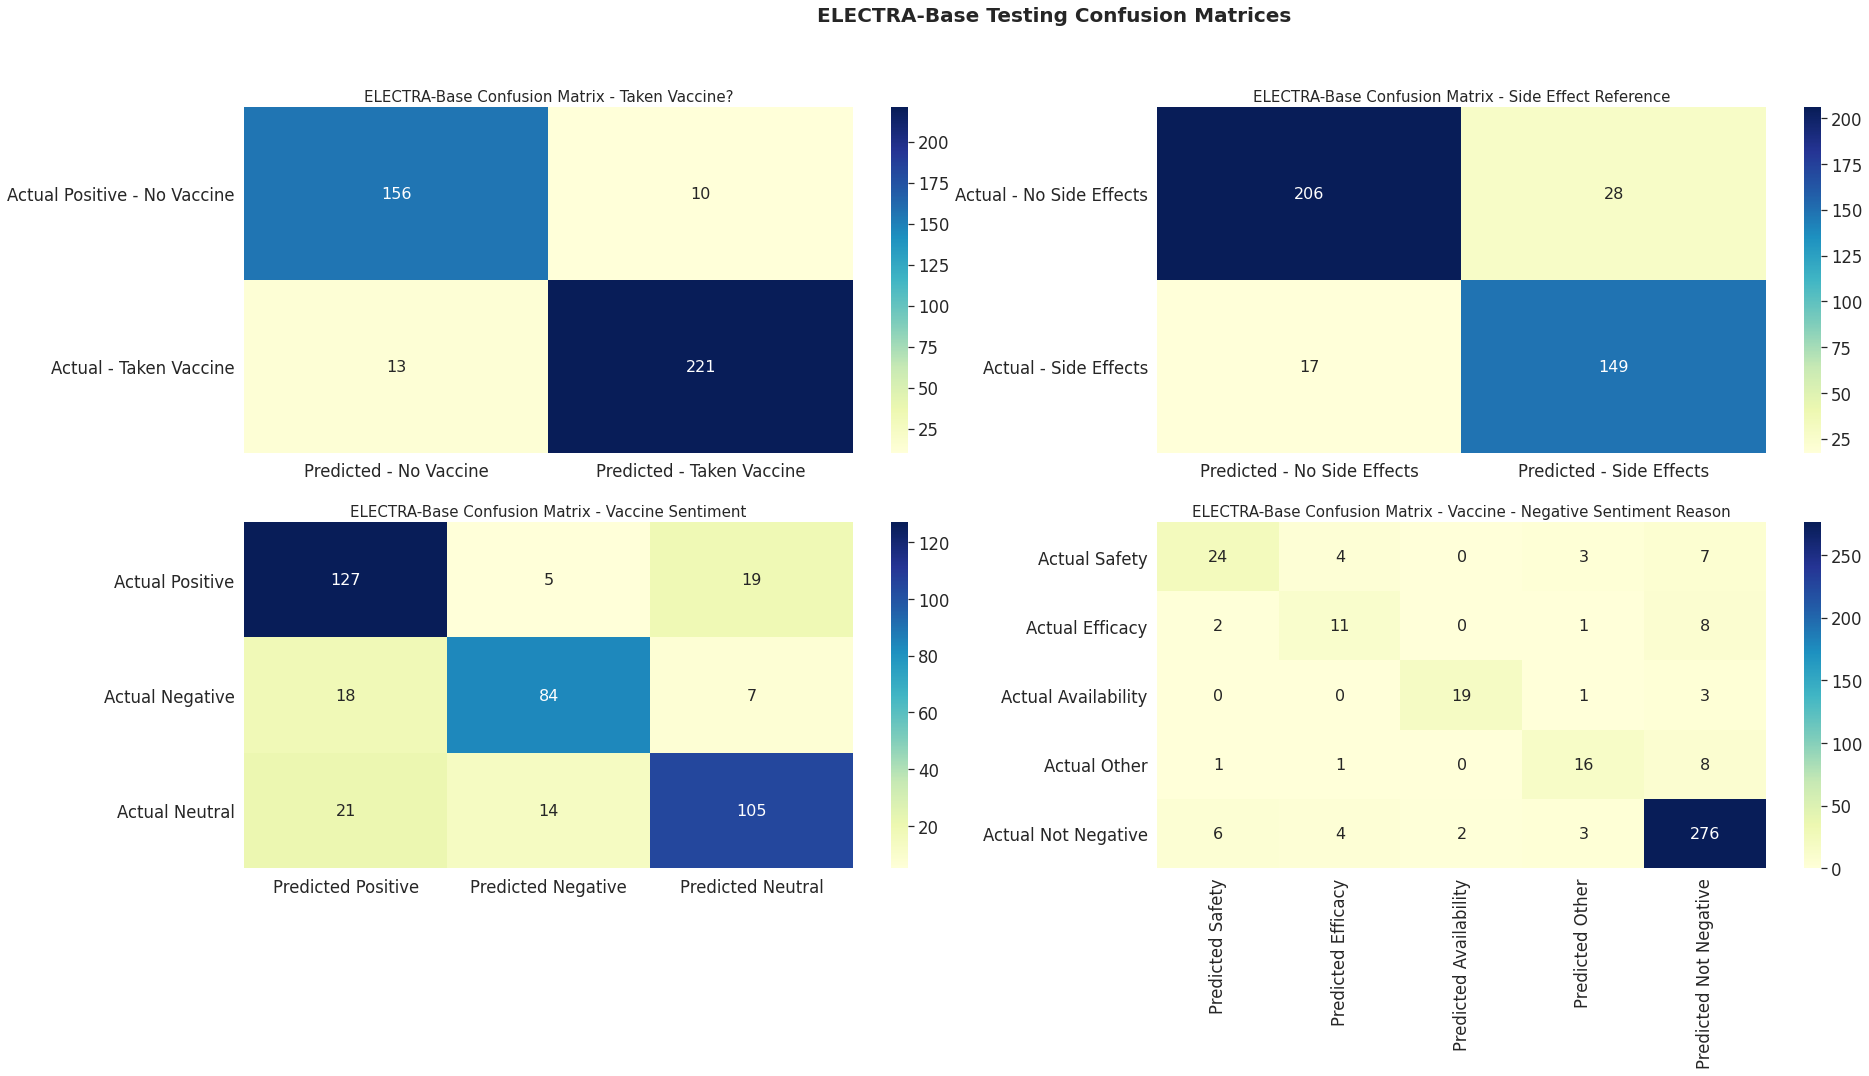

In [150]:
sn.set(font_scale=1.5)
fig, axes = plt.subplots(2, 2, figsize=(30, 14))

fig.suptitle('ELECTRA-Base Testing Confusion Matrices',fontsize = 20,fontweight='bold')
a = sn.heatmap(cm_1, ax=axes[0,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')
a.set_title('ELECTRA-Base Confusion Matrix - Taken Vaccine?',fontsize = 15)
b = sn.heatmap(cm_2, ax=axes[0,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')
b.set_title('ELECTRA-Base Confusion Matrix - Side Effect Reference',fontsize = 15)
c = sn.heatmap(cm_3,ax=axes[1,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')
c.set_title('ELECTRA-Base Confusion Matrix - Vaccine Sentiment',fontsize = 15)
d = sn.heatmap(data=cm_4, ax=axes[1,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')
d.set_title('ELECTRA-Base Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

# BERT EN UNCASED Model Evaluation

In [151]:
tf.random.set_seed(3)

## BERT EN UNCASED Classifier - Vaccine Classification

In [152]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [153]:
# train_size = int(0.7 * len(m1_dataset))
# val_size = int(0.10 * len(m1_dataset))
# test_size = int(0.20 * len(m1_dataset))


# full_dataset = m1_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [154]:

epochs = 10

checkpoint_filepath = './m1_bert_uncased/checkpoint'
model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m1_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)


In [155]:
bert_uncased_m1 = build_classifier_model_binary()

KeyboardInterrupt: ignored

In [ ]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [ ]:
bert_uncased_m1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m1.fit(m1_train_dataset,validation_data=m1_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

In [ ]:
bert_uncased_m1.load_weights(checkpoint_filepath)

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
loss, accuracy, f1, precision, recall = bert_uncased_m1.evaluate(m1_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

In [ ]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m1_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifier_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_uncased_m1.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [ ]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]


# count = 0 

# while count < len(text_list):
#   print(text_list[count], predicted_categories[count], true_label_list[count])
#   count += 1


In [ ]:
cm_1 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_1, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Taken Vaccine?',fontsize = 15)

In [ ]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m1', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

##BERT EN UNCASED Classifier - Side-Effect Determination

In [ ]:
# train_size = int(0.7 * len(m2_dataset))
# val_size = int(0.10 * len(m2_dataset))
# test_size = int(0.20 * len(m2_dataset))


# full_dataset = m2_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [ ]:
epochs = 10

checkpoint_filepath = './m2_bert_uncased/checkpoint'

model_checkpoint_callback = create_checkpoint_callback(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m2_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [ ]:
bert_uncased_m2 = build_classifier_model_binary()


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
      'binary_accuracy',
      f1_m,
      precision_m, 
      recall_m
]


In [ ]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [ ]:
bert_uncased_m2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m2.fit(m2_train_dataset,validation_data=m2_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

In [ ]:
bert_uncased_m2.load_weights(checkpoint_filepath)

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
loss, accuracy, f1, precision, recall = bert_uncased_m2.evaluate(m2_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

In [ ]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m2_test_dataset.as_numpy_iterator()):

  for item in batch[0]:

    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.sigmoid(bert_uncased_m2.predict(tf.constant([item])))
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

  for item in batch[1]:
    true_label_list.append(item)


In [ ]:
predicted_categories = [0 if x < .5 else 1 for x in y_pred_list]

'''
count = 0 

while count < len(text_list):
  print(text_list[count], predicted_categories[count], true_label_list[count])
  count += 1
'''

In [ ]:
cm_2 = confusion_matrix(true_label_list, predicted_categories)


plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_2, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Side Effect Reference',fontsize = 15)

In [ ]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, predicted_categories, average="micro"))
print("Recall Score: ", recall_score(true_label_list, predicted_categories, average="micro"))
print("f1 Score: ", f1_score(true_label_list, predicted_categories, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, predicted_categories))

# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, predicted_categories, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, predicted_categories, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, predicted_categories, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, predicted_categories, average="micro")
test_recall = recall_score(true_label_list, predicted_categories, average="micro")
test_f1 = f1_score(true_label_list, predicted_categories, average="micro")
test_accuracy = accuracy_score(true_label_list, predicted_categories)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, predicted_categories, average="macro")
test_macro_recall = recall_score(true_label_list, predicted_categories, average="macro")
test_macro_f1 = f1_score(true_label_list, predicted_categories, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m2', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

##BERT EN UNCASED Classifier - Sentiment Analysis

In [ ]:
# train_size = int(0.7 * len(m3_dataset))
# val_size = int(0.10 * len(m3_dataset))
# test_size = int(0.20 * len(m3_dataset))


# full_dataset = m3_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [ ]:
epochs = 10

checkpoint_filepath = './m3_bert_uncased_/checkpoint'

model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m3_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [ ]:
bert_uncased_m3 = build_classifier_model_softmax_3_class()


In [ ]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [ ]:
bert_uncased_m3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m3.fit(m3_train_dataset,validation_data=m3_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

In [ ]:
bert_uncased_m3.load_weights(checkpoint_filepath)

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
loss, accuracy, f1, precision, recall = bert_uncased_m3.evaluate(m3_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

In [ ]:
model_final_test_results.append((bert_model_name, 'bert_uncased_m3', loss, accuracy,precision,recall,f1))

In [ ]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m3_test_dataset.as_numpy_iterator()):

  for item in batch[0]:


    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.argmax(bert_uncased_m3.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

    

  for item in batch[1]:
    true_label_list.append(tf.argmax(item))


In [ ]:
cm_3 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_3, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Vaccine Sentiment',fontsize = 15)

In [ ]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m3', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

##BERT EN UNCASED Classifier - Negative Sentiment Reason

In [ ]:
# train_size = int(0.7 * len(m4_dataset))
# val_size = int(0.10 * len(m4_dataset))
# test_size = int(0.20 * len(m4_dataset))


# full_dataset = m4_dataset.shuffle(buffer_size=16)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [ ]:
epochs = 10

checkpoint_filepath = './m4_bert_uncased_/checkpoint'
model_checkpoint_callback = create_checkpoint_callback_categorical(checkpoint_filepath)


steps_per_epoch = tf.data.experimental.cardinality(m4_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [ ]:
bert_uncased_m4 = build_classifier_model_softmax_5_class()

In [ ]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = [
      'categorical_accuracy',
      f1_m,
      precision_m, 
      recall_m
]

In [ ]:
bert_uncased_m4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_uncased_m4.fit(m4_train_dataset,validation_data=m4_val_dataset, epochs=epochs, callbacks =[model_checkpoint_callback])

In [ ]:
bert_uncased_m4.load_weights(checkpoint_filepath)

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
loss, accuracy, f1, precision, recall = bert_uncased_m4.evaluate(m4_test_dataset, verbose=0)
print('Test Accuracy: %f'% (accuracy*100))
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test f1_score: ', f1)

In [ ]:
# Generate Cofnusion Matrix from test_dataset - binary classification


text_list = list()
true_label_list = list()
y_pred_list = list()


for batch in list(m4_test_dataset.as_numpy_iterator()):

  for item in batch[0]:


    #print(tf.sigmoid(classifi  er_model.predict(tf.constant([item]))))
    y_pred = tf.argmax(bert_uncased_m4.predict(tf.constant([item])),1)
    y_pred_list.append(y_pred)

    text_list.append(item)
    #y_pred.append(pred)

    

  for item in batch[1]:
    true_label_list.append(tf.argmax(item))

In [ ]:

cm_4 = confusion_matrix(true_label_list, y_pred_list)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_4, annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

ax.set_title('Bert-Uncased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

In [ ]:

# Print f1, precision, and recall scores
print("Precision Score: ",  precision_score(true_label_list, y_pred_list, average="micro"))
print("Recall Score: ", recall_score(true_label_list, y_pred_list, average="micro"))
print("f1 Score: ", f1_score(true_label_list, y_pred_list, average="micro"))
print('Accuracy Score', accuracy_score(true_label_list, y_pred_list))


# Print f1, precision, and recall scores
print("Macro Precision Score: ",  precision_score(true_label_list, y_pred_list, average="macro"))
print("Macro Recall Score: ", recall_score(true_label_list, y_pred_list, average="macro"))
print("Macro f1 Score: ", f1_score(true_label_list, y_pred_list, average="macro"))


# Calculate recall through sklearn packages. Allows specification of 'micro' averaging
test_precision = precision_score(true_label_list, y_pred_list, average="micro")
test_recall = recall_score(true_label_list, y_pred_list, average="micro")
test_f1 = f1_score(true_label_list, y_pred_list, average="micro")
test_accuracy = accuracy_score(true_label_list, y_pred_list)


# Calculate recall through sklearn packages. Allows specification of 'macro' averaging
test_macro_precision = precision_score(true_label_list, y_pred_list, average="macro")
test_macro_recall = recall_score(true_label_list, y_pred_list, average="macro")
test_macro_f1 = f1_score(true_label_list, y_pred_list, average="macro")


model_final_test_results.append((bert_model_name, 'bert_uncased_m4', loss,  test_precision, test_recall, test_f1, test_accuracy, test_macro_precision, test_macro_recall, test_macro_f1))

In [ ]:
sn.set(font_scale=1.5)
fig, axes = plt.subplots(2, 2, figsize=(30, 14))

fig.suptitle('BERT-Uncased Testing Confusion Matrices',fontsize = 20,fontweight='bold')
a = sn.heatmap(cm_1, ax=axes[0,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Vaccine','Predicted - Taken Vaccine'],
           yticklabels=['Actual Positive - No Vaccine','Actual - Taken Vaccine'],fmt='d')
a.set_title('BERT-Uncased Confusion Matrix - Taken Vaccine?',fontsize = 15)
b = sn.heatmap(cm_2, ax=axes[0,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted - No Side Effects','Predicted - Side Effects'],
           yticklabels=['Actual - No Side Effects','Actual - Side Effects'],fmt='d')
b.set_title('BERT-Uncased Confusion Matrix - Side Effect Reference',fontsize = 15)
c = sn.heatmap(cm_3,ax=axes[1,0], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Positive','Predicted Negative','Predicted Neutral'],
           yticklabels=['Actual Positive','Actual Negative','Actual Neutral'],fmt='d')
c.set_title('BERT-Uncased Confusion Matrix - Vaccine Sentiment',fontsize = 15)
d = sn.heatmap(data=cm_4, ax=axes[1,1], annot=True, annot_kws={"size": 16}, cmap="YlGnBu",xticklabels=['Predicted Safety','Predicted Efficacy','Predicted Availability','Predicted Other','Predicted Not Negative'],
           yticklabels=['Actual Safety','Actual Efficacy','Actual Availability','Actual Other','Actual Not Negative'],fmt='d')
d.set_title('BERT-Uncased Confusion Matrix - Vaccine - Negative Sentiment Reason',fontsize = 15)

# Save Results to Excel

In [156]:
model_final_test_results

[('bert_en_cased_L-12_H-768_A-12',
  'bert_cased_m1',
  0.5569255352020264,
  0.8925,
  0.8925,
  0.8925,
  0.8925,
  0.8886169064296654,
  0.8984914015034497,
  0.8909950504147892),
 ('bert_en_cased_L-12_H-768_A-12',
  'bert_cased_m2',
  0.9974595904350281,
  0.87,
  0.87,
  0.87,
  0.87,
  0.8657635467980296,
  0.8670064874884151,
  0.8663616972064455),
 ('bert_en_cased_L-12_H-768_A-12',
  'bert_cased_m3',
  1.5134820938110352,
  0.7575,
  0.7575,
  0.7575,
  0.7575,
  0.75681402094403,
  0.7478254768703763,
  0.7506231595648817),
 ('bert_en_cased_L-12_H-768_A-12',
  'bert_cased_m4',
  1.193010687828064,
  0.81,
  0.81,
  0.81,
  0.81,
  0.6535268652915711,
  0.5783251812315957,
  0.6105527902071788),
 ('electra_base',
  'electra_base_m1',
  0.34022247791290283,
  0.9425,
  0.9425,
  0.9425,
  0.9425,
  0.93989343989344,
  0.9421017402945113,
  0.9409404589953458),
 ('electra_base',
  'electra_base_m2',
  0.8031043410301208,
  0.8875,
  0.8875,
  0.8875,
  0.8875,
  0.882787362874008

In [157]:
results = pd.DataFrame(model_final_test_results)

In [158]:
from datetime import datetime

In [159]:
results['timestamp'] = datetime.now()

In [160]:
results = results.rename(columns={0: "TensorHub Model Name", 1: "Classifier Task Name", 2: "Test Loss",3:'Test Micro Precision',4:'Test Micro Recall',5:'Test Micro F1 Score',6:'Test Accuracy',7:'Test Macro Precision',8:'Test Macro Recall',9:'Test Macro F1'})

In [161]:
results.to_excel('Covid_Vaccine_Classifier_Results_5_26_3.xlsx')